### Install required libraries

In [2]:
!pip install -q gdown patool numpy pandas matplotlib torch torchvision timm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import gdown
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from timm.loss import LabelSmoothingCrossEntropy # Better than nn.CrossEntropyLoss

%matplotlib inline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download training and validation data from Google Drive

In [4]:
file_id = "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
file_name = "Project_data.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name)

Downloading...
From (original): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
From (redirected): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t&uuid=0b53120a-1ad7-42d4-b4b3-365de17ac10b
To: /kaggle/working/Project_data.zip
100%|██████████| 1.71G/1.71G [00:07<00:00, 238MB/s] 


'Project_data.zip'

In [5]:
# Remove extracted files if already exist
!rm -rf 'Project_data'
# Unzip file
!unzip -qq Project_data.zip

In [6]:
data_root_dir = "Project_data"
train_images_dir = os.path.join(data_root_dir, 'train')
val_images_dir = os.path.join(data_root_dir, 'val')
train_csv_file = os.path.join(data_root_dir, 'train.csv')
val_csv_file = os.path.join(data_root_dir, 'val.csv')

In [7]:
train_data_df = pd.read_csv(train_csv_file)
df = pd.DataFrame(train_data_df.iloc[:, 0].str.split(';').tolist(), columns = ['folder', 'label','class'])
classes = df['class'].unique()

In [8]:
# Hyperparameters
torch.manual_seed(2809)
num_epochs = 20
batch_size = 4
image_size = 256
learning_rate = 0.001

In [9]:
class CustomVideoDataset(Dataset):

  def __init__(self, images_dir, data_file, transform):

    self.images_dir = images_dir
    self.transform = transform
    data_df = pd.read_csv(data_file)
    self.data = data_df.iloc[:, 0].str.split(';')

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    images = []
    images_path = os.path.join(self.images_dir, self.data[index][0])
    # print(f'Loading video images from folder {images_path}')
    for image_file in os.scandir(images_path):
      image = Image.open(os.path.join(image_file))
      if self.transform:
        image = self.transform(image)
      images.append(image)

    label = self.data[index][2]

    images = torch.stack(images)
    labels = torch.tensor(int(label), dtype=torch.long)

    return images, labels


In [10]:
transform = transforms.Compose([
  transforms.Resize((image_size, image_size)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = CustomVideoDataset(train_images_dir, train_csv_file, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

val_dataset = CustomVideoDataset(val_images_dir, val_csv_file, transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [11]:
def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

Train images shape: torch.Size([4, 30, 3, 256, 256])


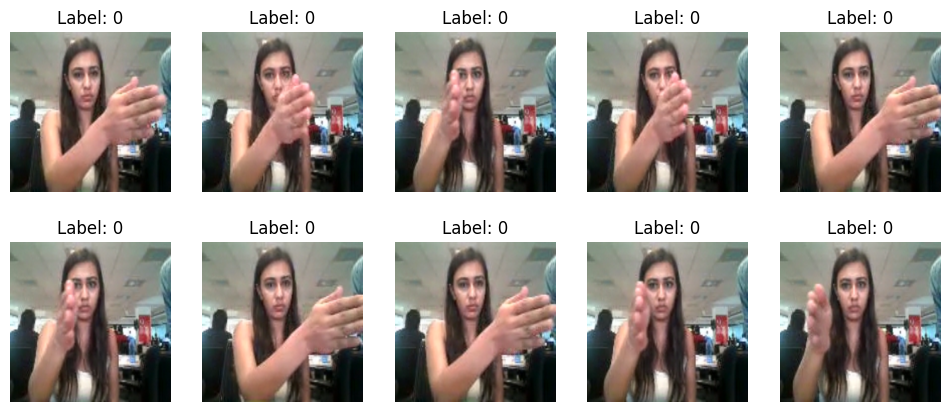

In [12]:
batch_of_video_image_frames, labels = next(iter(train_loader))
print(f'Train images shape: {batch_of_video_image_frames.shape}')

_, axs = plt.subplots(2, 5, figsize=(12, 5))

index = 0
for row in range(2):
  for col in range(5):
    input_tensor= inverse_normalize(tensor=batch_of_video_image_frames[0][index])
    img = input_tensor.squeeze(0)
    axs[row, col].imshow(transforms.ToPILImage()(img))
    axs[row, col].set_title('Label: ' + str(labels[0].item()))
    axs[row, col].axis('off')
    index += 1

In [13]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNLSTM, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x_3d):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t])
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

        # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.fc1(hidden[0][-1])
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [14]:
model = CNNLSTM()
model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s] 


In [15]:
class SaveBestModel:

  def __init__(self, best_valid_loss=float('inf')):
    self.best_valid_loss = best_valid_loss

  def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
    if current_valid_loss < self.best_valid_loss:
      self.best_valid_loss = current_valid_loss
      print(f'Best validation loss: {self.best_valid_loss}')
      print(f'Saving best model for epoch: {epoch+1}')
      torch.save({
          'epoch': epoch+1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': criterion,
      }, 'best_model.pth')

In [16]:
def save_model(epochs, model, optimizer, criterion):
  print(f"Saving final model...")
  torch.save({
              'epoch': epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': criterion,
              }, 'final_model.pth')

In [17]:
# initialize SaveBestModel class
save_best_model = SaveBestModel()

In [18]:
def train(epoch, model, train_loader, optimizer, criterion):

  model.train()

  running_loss, running_corrects, running_total = 0.0, 0, 0

  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for i, (inputs, labels) in enumerate(tepoch):
      tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

      optimizer.zero_grad()

      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      loss = criterion(outputs, labels)

      predictions = torch.argmax(outputs, dim=1)
      corrects = (predictions == labels).sum().item()
      accuracy = corrects / inputs.size(0)

      running_loss += loss.item() * inputs.size(0)
      running_total += labels.size(0)
      running_corrects += corrects

      loss.backward()
      optimizer.step()

      tepoch.set_postfix(train_loss=loss.item(), train_accuracy=100. * accuracy)

      # print(f'running_total: {running_total}; running_loss: {running_loss}; running_corrects: {running_corrects}')

  # Calculate the training loss and training accuracy
  train_loss = running_loss / running_total
  train_accuracy = 100 * running_corrects / running_total
  # print(f'Epoch {epoch} - Training loss: {train_loss:.4f} Training accuracy: {train_accuracy:.2f}')
  return train_loss, train_accuracy


In [19]:
def validate(epoch, model, val_loader, criterion):

  running_val_loss, running_val_corrects, running_val_total = 0.0, 0, 0

  # Validation
  with torch.no_grad():
    model.eval()
    with tqdm(val_loader, unit="batch", total=len(val_loader)) as tepoch:
      for i, (inputs, labels) in enumerate(tepoch):
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
        corrects = (predictions == labels).sum().item()
        accuracy = corrects / inputs.size(0)

        tepoch.set_postfix(validation_loss=loss.item(), validation_accuracy=100. * accuracy)

        running_val_loss += loss.item() * inputs.size(0)
        running_val_total += labels.size(0)
        running_val_corrects += corrects

  # Calculate the training loss and training accuracy
  val_loss = running_val_loss / running_val_total
  val_accuracy = 100 * running_val_corrects / running_val_total
  # print(f'Epoch {epoch} - Validation loss: {val_loss:.4f} Validation accuracy: {val_accuracy:.2f}')
  return val_loss, val_accuracy


In [20]:
metrics = {'train_loss' : [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(num_epochs):
  train_loss, train_accuracy = train(epoch, model, train_loader, optimizer, criterion)
  val_loss, val_accuracy = validate(epoch, model, val_loader, criterion)
  metrics['train_loss'].append(train_loss)
  metrics['train_accuracy'].append(train_accuracy)
  metrics['val_loss'].append(val_loss)
  metrics['val_accuracy'].append(val_accuracy)
  save_best_model(val_loss, epoch, model, optimizer, criterion)


save_model(num_epochs, model, optimizer, criterion)

Epoch 1/20: 100%|██████████| 25/25 [00:09<00:00,  2.51batch/s, validation_accuracy=33.3, validation_loss=1.58]


Best validation loss: 1.6100921341867158
Saving best model for epoch: 1


Epoch 2/20: 100%|██████████| 25/25 [00:10<00:00,  2.37batch/s, validation_accuracy=66.7, validation_loss=1.54]


Best validation loss: 1.5838515264819366
Saving best model for epoch: 2


Epoch 3/20: 100%|██████████| 25/25 [00:10<00:00,  2.46batch/s, validation_accuracy=0, validation_loss=1.92]   


Best validation loss: 1.383661858963244
Saving best model for epoch: 3


Epoch 5/20: 100%|██████████| 25/25 [00:09<00:00,  2.52batch/s, validation_accuracy=0, validation_loss=1.51]  


Best validation loss: 1.2078304989169342
Saving best model for epoch: 5


Epoch 15/20: 100%|██████████| 25/25 [00:10<00:00,  2.31batch/s, validation_accuracy=0, validation_loss=1.42]   


Best validation loss: 1.1281834395244867
Saving best model for epoch: 15


Epoch 16/20: 100%|██████████| 25/25 [00:10<00:00,  2.48batch/s, validation_accuracy=100, validation_loss=1.02] 


Best validation loss: 1.0562484589490024
Saving best model for epoch: 16


Epoch 18/20: 100%|██████████| 25/25 [00:10<00:00,  2.49batch/s, validation_accuracy=33.3, validation_loss=1.04]


Best validation loss: 0.9753172650481715
Saving best model for epoch: 18


Epoch 19/20: 100%|██████████| 25/25 [00:10<00:00,  2.36batch/s, validation_accuracy=33.3, validation_loss=0.938]


Best validation loss: 0.9581040884509231
Saving best model for epoch: 19


Epoch 20/20: 100%|██████████| 25/25 [00:09<00:00,  2.52batch/s, validation_accuracy=66.7, validation_loss=1.05]


Saving final model...


In [21]:
def plot_metrics_charts(metrics):
    acc = metrics['train_accuracy']
    val_acc = metrics['val_accuracy']

    loss = metrics['train_loss']
    val_loss = metrics['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()

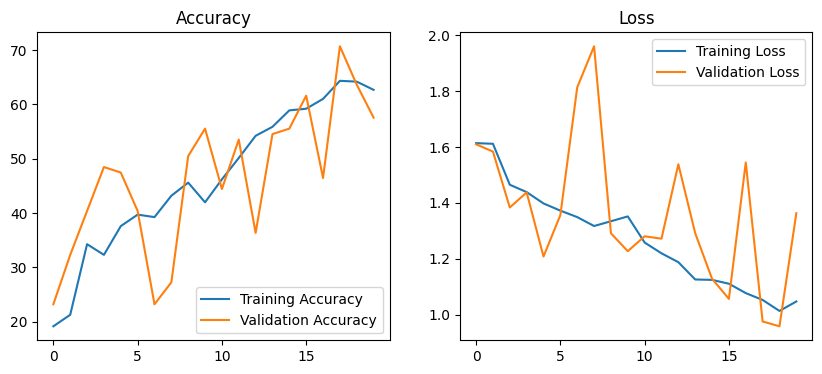

In [22]:
plot_metrics_charts(metrics)